In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Hiperparámetros
learning_rate = 0.001
num_epochs = 50
batch_size = 32

In [3]:
# Transformaciones para los datos
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
# Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(f"{self.root_dir}/{img_name}").convert("RGB")
        category = self.data.iloc[idx, 1]
        subcategory = self.data.iloc[idx, 2]
        label = (category, subcategory)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Red neuronal convolucional
class CNN(nn.Module):
    def __init__(self, num_classes_main, num_classes_secondary):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes_main)
        self.fc3_playa = nn.Linear(512, num_classes_secondary[0])
        self.fc3_pueblo = nn.Linear(512, num_classes_secondary[1])

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        main_out = self.fc2(x)
        playa_out = self.fc3_playa(x)
        pueblo_out = self.fc3_pueblo(x)
        return main_out, playa_out, pueblo_out

In [6]:
# Cargar los datasets
train_dataset = CustomDataset(csv_file='train_labels.csv', root_dir='dataset/train', transform=transform)
val_dataset = CustomDataset(csv_file='val_labels.csv', root_dir='dataset/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:

# Inicializar modelo, criterio de pérdida y optimizador
num_playa_classes = 356  # Número de subcategorías para playas
num_pueblo_classes = 131  # Número de subcategorías para pueblos

model = CNN(num_classes_main=2, num_classes_secondary=(num_playa_classes, num_pueblo_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
# Función para calcular la precisión
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = (preds == labels).sum().item()
    return corrects / len(labels)

In [12]:
# Función para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            category_labels, subcategory_labels = labels

            optimizer.zero_grad()

            main_outputs, playa_outputs, pueblo_outputs = model(inputs)
            main_loss = criterion(main_outputs, category_labels)

            playa_indices = category_labels == 0
            pueblo_indices = category_labels == 1

            playa_loss = criterion(playa_outputs[playa_indices], subcategory_labels[playa_indices]) if playa_indices.any() else 0
            pueblo_loss = criterion(pueblo_outputs[pueblo_indices], subcategory_labels[pueblo_indices]) if pueblo_indices.any() else 0

            loss = main_loss + playa_loss + pueblo_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_corrects += calculate_accuracy(main_outputs, category_labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

         # Validación
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                category_labels, subcategory_labels = labels

                main_outputs, playa_outputs, pueblo_outputs = model(inputs)
                main_loss = criterion(main_outputs, category_labels)

                playa_indices = category_labels == 0
                pueblo_indices = category_labels == 1

                playa_loss = criterion(playa_outputs[playa_indices], subcategory_labels[playa_indices]) if playa_indices.any() else 0
                pueblo_loss = criterion(pueblo_outputs[pueblo_indices], subcategory_labels[pueblo_indices]) if pueblo_indices.any() else 0

                loss = main_loss + playa_loss + pueblo_loss

                val_loss += loss.item()
                val_corrects += calculate_accuracy(main_outputs, category_labels)

            val_epoch_loss = val_loss / len(val_loader)
            val_epoch_acc = val_corrects / len(val_loader)
            val_losses.append(val_epoch_loss)
            val_accuracies.append(val_epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    print('Entrenamiento completado.')

     # Graficar pérdida y precisión
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

Epoch 1/50, Train Loss: 11.0506, Train Acc: 0.8074, Val Loss: 5.7700, Val Acc: 0.8531
Epoch 2/50, Train Loss: 10.3907, Train Acc: 0.8582, Val Loss: 5.4627, Val Acc: 0.8826
Epoch 3/50, Train Loss: 9.6435, Train Acc: 0.8734, Val Loss: 5.2188, Val Acc: 0.8574
Epoch 4/50, Train Loss: 8.4181, Train Acc: 0.8778, Val Loss: 4.8335, Val Acc: 0.8841
Epoch 5/50, Train Loss: 6.7764, Train Acc: 0.8930, Val Loss: 4.6230, Val Acc: 0.8808
Epoch 6/50, Train Loss: 4.8776, Train Acc: 0.9038, Val Loss: 4.4416, Val Acc: 0.8756
Epoch 7/50, Train Loss: 2.9297, Train Acc: 0.9171, Val Loss: 4.5591, Val Acc: 0.8828
Epoch 8/50, Train Loss: 1.5444, Train Acc: 0.9377, Val Loss: 4.7473, Val Acc: 0.8800
Epoch 9/50, Train Loss: 0.8347, Train Acc: 0.9516, Val Loss: 5.5694, Val Acc: 0.8730
Epoch 10/50, Train Loss: 0.5037, Train Acc: 0.9721, Val Loss: 5.2696, Val Acc: 0.8921
Epoch 11/50, Train Loss: 0.3430, Train Acc: 0.9845, Val Loss: 5.3726, Val Acc: 0.8912
Epoch 12/50, Train Loss: 0.1798, Train Acc: 0.9949, Val Loss:

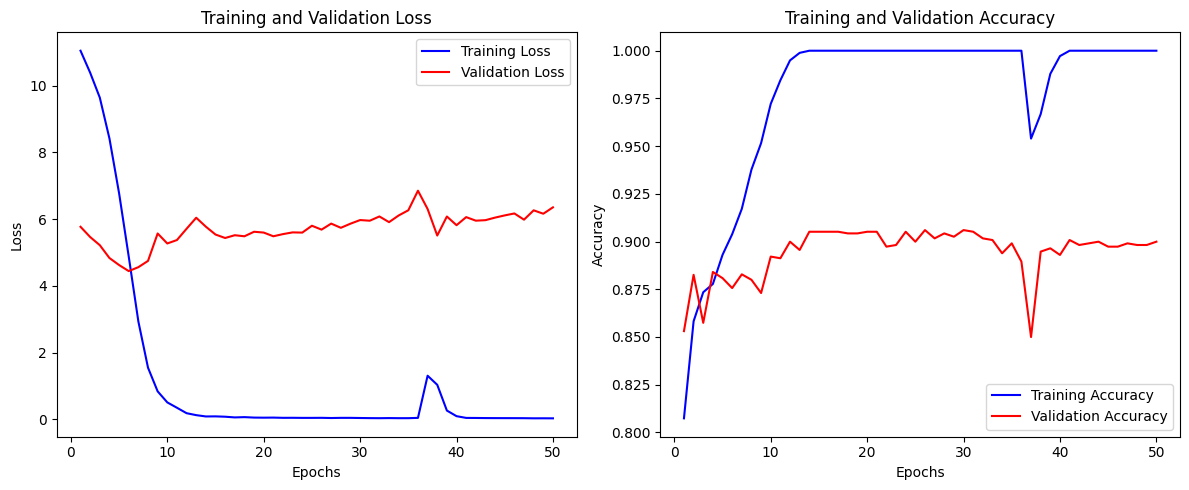

In [13]:
# Entrenar el modelo
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [14]:
# Guardar el modelo
torch.save(model.state_dict(), 'modeloCNN.pth')